<img src="../Images/imzeregions.png" alt="Drawing" style="width:750px;"/>

Spots per line: there are 1071 columns in per row/line <br>
Number of lines: #303 rows <br>

|<p>   |  <p> |
|:-:|:-:|
|<img src="../Images/spec1182.png" alt="Drawing" style="width:500px;"/> |  <img src="../Images/spec1182_pp.png" alt="Drawing" style="width:500px;"/> |

``` python
(imze.parser.getspectrum(1310)[0] == imze.parser.getspectrum(100)[0]).all()
>> False

(imze.parser.getspectrum(1310)[0] == imze.parser.getspectrum(100)[0]).all()
>> True
```

<img src="../Images/standardization.png" alt="Drawing" style="width:500px;"/>

Standardize features by removing the mean and scaling to unit variance.

### Correlation between features(Correlation matrix)

<img src="../Images/correlation.png" alt="Drawing" style="width:500px;"/>

### Dimensionality reduction(PCA)

|<p>   |  <p> |
|:-:|:-:|
|<img src="../Images/PCA.png" alt="Drawing" style="width:500px;"/> |  <img src="../Images/PCA_2.png" alt="Drawing" style="width:500px;"/> |

<img src="../Images/PCA_r.png" alt="Drawing" style="width:850px;"/>

|<p>   |  <p> |
|:-:|:-:|
|<img src="../Images/screeplot1.png" alt="Drawing" style="width:500px;"/> |  <img src="../Images/screeplot2.png" alt="Drawing" style="width:500px;"/> |

### Clustering in unsupervised learning:

|<p>   |  <p> |
|:-:|:-:|
|<img src="../Images/aggclus.png" alt="Drawing" style="width:500px;"/> |  <img src="../Images/aggcluspca300.png" alt="Drawing" style="width:500px;"/> |

Spatially aware shrunken centroid algorithm(R/Cardinal)

<img src="../Images/spatialshrunkencentroid.png" alt="Drawing" style="width:850px;"/>

<img src="../Images/statR.png" alt="Drawing" style="width:500px;"/>

### Manifold learning with t-SNE
mainly aimed at visualisation

<img src="../Images/tsne.png" alt="Drawing" style="width:500px;"/>

## <span style="color:Purple">pIMZ functionalities<span>
to check the number of spectrums in an image file(all regions combined). 
```python
len(imze.parser.mzLengths)    
```

###  Libraries

In [1]:
from glob import glob
import os
from imzml import IMZMLExtract
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
import mglearn
from sklearn.preprocessing import StandardScaler
import rpy2.robjects as robjects
from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets import make_blobs

In [2]:
class Binning(object):
    """
    given the imze object should create 3D matrix(spatial based) or 2D(spectrum based)
    spectrum: array with 2 vectors, one of abundance(1), other with m/z values(0)
    n_bins: number of bins/samples to be digitized
    plotspec: to plot the new binned spectrum, default--> True
    """
    def __init__(self, imzObj, regionID, n_bins, plotspec=False):
        self.imzObj = imzObj
        self.regionID = regionID
#         self.n_bins = n_bins
        self.n_bins = len(imzObj.mzValues) + 1  #
        self.plotspec = plotspec
    
        self.xr, self.yr, self.zr, _ = self.imzObj.get_region_range(regionID)
        self.imzeShape = [self.xr[1]-self.xr[0]+1,
                 self.yr[1]-self.yr[0]+1, self.n_bins -1]

    def getBinMat(self):
        sarray = np.zeros(self.imzeShape, dtype=np.float32)
        regInd = self.imzObj.get_region_indices(self.regionID)
        binned_mat = np.zeros([len(regInd), self.n_bins - 1])
        coordList = []
#         xr, yr, zr, _ = self.imzObj.get_region_range(regionID)
#         self.imzeShape = [xr[1]-xr[0]+1,
#                  yr[1]-yr[0]+1, self.n_bins -1]
        for i, coord in enumerate(regInd):
            spectrum = self.imzObj.parser.getspectrum(self.imzObj.coord2index.get(coord)) #[0]
            bSpec = self.onebinning(spectrum)
            binned_mat[i] = bSpec
            xpos = coord[0]-self.xr[0]
            ypos = coord[1]-self.yr[0]
            sarray[xpos, ypos, :] = bSpec
            coordList.append(coord)
        return sarray, binned_mat, coordList

    def onebinning(self, spectrum):
        """
        returns: binned_spectrum
        """
        bins = np.linspace(spectrum[0][0], spectrum[0][-1], num=self.n_bins, endpoint=True)
        hist = np.histogram(spectrum[0], bins=bins)
        binned_spectrum = np.zeros_like(hist[0])
        hstart = 0
        for i in range(len(hist[0])):
            binned_spectrum[i] = np.sum(spectrum[1][hstart:hstart + hist[0][i]])
            hstart = hstart + hist[0][i]
        if self.plotspec:
            plt.plot(bins[1:], binned_spectrum)
            plt.show()
        return binned_spectrum
    

# updated after Cardinal: peakpicked    
class Binning2(object):
    """
    given the imze object should create 3D matrix(spatial based) or 2D(spectrum based)
    spectrum: array with 2 vectors, one of abundance(1), other with m/z values(0)
    n_bins: number of bins/samples to be digitized
    plotspec: to plot the new binned spectrum, default--> True
    """
    def __init__(self, imzObj, regionID, plotspec=False):
        self.imzObj = imzObj
        self.regionID = regionID
        self.n_bins = len(imzObj.mzValues) + 1
        self.plotspec = plotspec
        self.xr, self.yr, self.zr, _ = self.imzObj.get_region_range(regionID)
        self.imzeShape = [self.xr[1]-self.xr[0]+1,
                 self.yr[1]-self.yr[0]+1, self.n_bins -1]

    def getBinMat(self):
        sarray = np.zeros(self.imzeShape, dtype=np.float32)
        regInd = self.imzObj.get_region_indices(self.regionID)
        binned_mat = np.zeros([len(regInd), self.n_bins - 1])
        coordList = []
#         xr, yr, zr, _ = self.imzObj.get_region_range(regionID)
#         self.imzeShape = [xr[1]-xr[0]+1,
#                  yr[1]-yr[0]+1, self.n_bins -1]
        for i, coord in enumerate(regInd):
            spectrum = self.imzObj.parser.getspectrum(self.imzObj.coord2index.get(coord)) #[0]
            bSpec = self.onebinning(spectrum)
            binned_mat[i] = bSpec
            xpos = coord[0]-self.xr[0]
            ypos = coord[1]-self.yr[0]
            sarray[xpos, ypos, :] = bSpec
            coordList.append(coord)
        return sarray, binned_mat, coordList

    def onebinning(self, spectrum):
        """
        returns: binned_spectrum
        """
        bins = np.linspace(spectrum[0][0], spectrum[0][-1], num=self.n_bins, endpoint=True)
        hist = np.histogram(spectrum[0], bins=bins)
        binned_spectrum = np.zeros_like(hist[0])
        hstart = 0
        for i in range(len(hist[0])):
            binned_spectrum[i] = np.sum(spectrum[1][hstart:hstart + hist[0][i]])
            hstart = hstart + hist[0][i]
        if self.plotspec:
            plt.plot(bins[1:], binned_spectrum)
            plt.show()
        return binned_spectrum

In [3]:
# rfold = r'/media/banikr2/DATA/MALDI/mspeaks.RData'
# G = robjects.r['load'](rfold)

In [4]:
cardinalDir= r'/media/banikr2/DATA/MALDI/fromCardinal/'
imzPath = glob(os.path.join(cardinalDir, '*.imzML'))
print(imzPath[0])

/media/banikr2/DATA/MALDI/fromCardinal/210427-Chen_poslip-peakpicked.imzML


loaded peak spectrum images

In [5]:
imze = IMZMLExtract(imzPath[0])
# imze.dregions[1] # allpixels

/home/banikr2/.local/lib/python3.7/site-packages/pyimzML-1.5.1-py3.7.egg/pyimzml/ontology/ontology.py:94: UserWarning: Accession IMS:1000042 found with incorrect name "max count of pixel x". Updating name to "max count of pixels x".
  % (accession, raw_name, name)
/home/banikr2/.local/lib/python3.7/site-packages/pyimzML-1.5.1-py3.7.egg/pyimzml/ontology/ontology.py:94: UserWarning: Accession IMS:1000043 found with incorrect name "max count of pixel y". Updating name to "max count of pixels y".
  % (accession, raw_name, name)
/home/banikr2/.local/lib/python3.7/site-packages/pyimzML-1.5.1-py3.7.egg/pyimzml/ontology/ontology.py:94: UserWarning: Accession IMS:1000046 found with incorrect name "pixel size x". Updating name to "pixel size (x)".
  % (accession, raw_name, name)


Opening regions file for /media/banikr2/DATA/MALDI/fromCardinal/210427-Chen_poslip-peakpicked.imzML
1 545 628 244 291
2 695 785 244 303
3 704 798 146 212
4 848 940 201 265
5 988 1071 220 273


1 ((545, 628, 244, 291), 3142)
2 ((695, 785, 244, 303), 3975)
3 ((704, 798, 146, 212), 4587)
4 ((848, 940, 201, 265), 4680)
5 ((988, 1071, 220, 273), 3435)


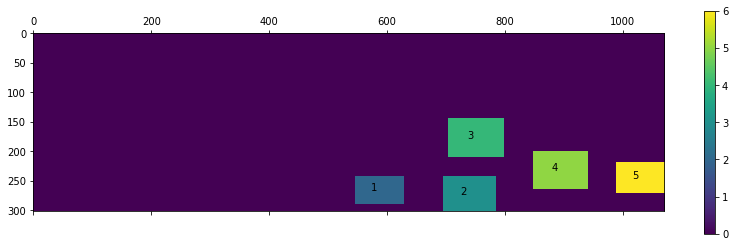

{1: ((545, 628, 244, 291), 3142),
 2: ((695, 785, 244, 303), 3975),
 3: ((704, 798, 146, 212), 4587),
 4: ((848, 940, 201, 265), 4680),
 5: ((988, 1071, 220, 273), 3435)}

In [6]:
imze.list_regions()

In [7]:
len(imze.parser.getspectrum(12)[1])

1332

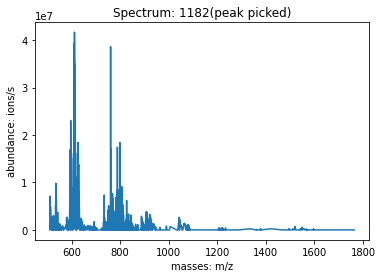

In [205]:
plt.plot(imze.parser.getspectrum(1182)[0], imze.parser.getspectrum(1182)[1])
plt.title("Spectrum: 1182(peak picked)")
plt.xlabel("masses: m/z")
plt.ylabel("abundance: ions/s")
plt.show()

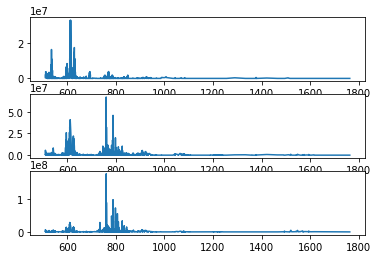

In [8]:
plt.subplot(311)
plt.plot(imze.parser.getspectrum(12)[0], imze.parser.getspectrum(12)[1])
plt.subplot(312)
plt.plot(imze.parser.getspectrum(600)[0], imze.parser.getspectrum(600)[1])
plt.subplot(313)
plt.plot(imze.parser.getspectrum(1331)[0], imze.parser.getspectrum(1331)[1])
plt.show()

In [9]:
(imze.parser.getspectrum(1310)[0] == imze.parser.getspectrum(100)[0]).all()

True

In [218]:
BinMat = Binning(imzObj=imze, regionID=2, n_bins=1332+1)

In [219]:
A = BinMat.getBinMat()

In [221]:
np.shape(A[1])

(3975, 1332)

In [222]:
np.max(A[1]), np.min(A[1]), np.mean(A[1]), np.std(A[1])

(631393280.0, 0.0, 1701436.8852112489, 8087076.698033347)

Correlation between scans

In [223]:
binMat = StandardScaler().fit_transform(A[1])

In [224]:
np.max(binMat[1]), np.min(binMat[1]), np.mean(binMat[1]), np.std(binMat[1])

(2.890221747770434,
 -2.2554003178464597,
 -0.27953183258791564,
 0.6692416928878605)

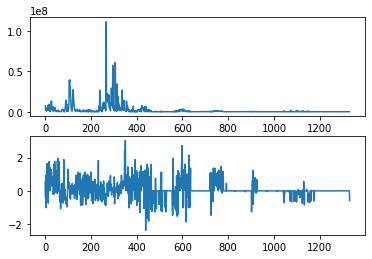

In [225]:
plt.subplot(211)
plt.plot(A[1][3001])
plt.subplot(212)
plt.plot(binMat[3001])
plt.show()

In [226]:
cList = np.array(A[2])
cList.shape

(3975, 3)

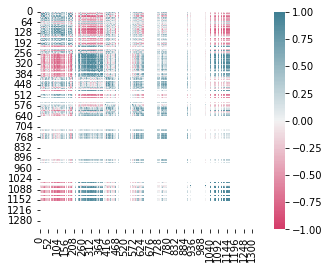

In [227]:
# data = pd.DataFrame(A[1])
data = pd.DataFrame(binMat)
corr = data.corr() # data
ax = sns.heatmap(corr,               #mat,
        vmin=-1, vmax=1, center=0,
        cmap=sns.diverging_palette(0, 220, n=200),
        square=True)

In [17]:
data

,0,1,2,3,4,5,6,7,8,9,...,1322,1323,1324,1325,1326,1327,1328,1329,1330,1331
0,1.015595,3.803954,1.134666,2.747360,1.624331,-0.142452,2.685882,-0.158721,0.272853,1.906453,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.246866
1,0.934940,2.148537,1.491265,1.367403,1.897450,-0.175464,0.240276,0.080368,-0.444961,0.532992,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.246866
2,-0.361847,0.695332,0.652043,0.128574,1.196615,-0.284682,0.680349,0.143456,-1.076269,0.390975,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.246866
3,-0.237935,0.110193,-0.634110,0.019335,0.393658,-0.277983,1.060934,2.144706,-0.247717,0.674942,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.246866
4,0.384519,0.572263,-0.133545,1.114902,1.371462,-0.194408,2.194525,1.523417,0.055554,0.949033,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.246866
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3137,0.027872,0.122297,0.918569,0.174800,0.472771,-0.251347,-0.404457,1.490201,-0.263929,1.464951,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.246866
3138,0.477351,0.068303,-1.134584,-0.037015,0.716064,-0.279471,0.742364,0.557759,-0.156736,1.832780,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.246866
3139,0.453532,-0.261264,-0.425802,-0.068164,0.182384,-0.188283,0.534946,2.513760,0.514778,1.548635,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.246866
3140,0.146674,-0.074679,-0.738997,0.080538,0.512806,-0.267465,-0.017769,2.677970,0.846317,1.364507,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.246866


PCA

(3975, 300)


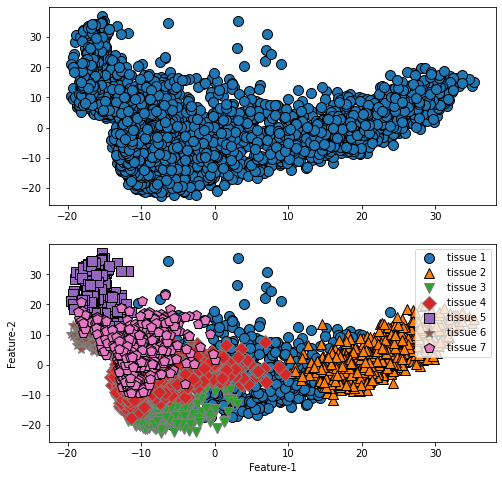

In [229]:
pca = PCA(n_components=300)
# pca.fit_transform(binMat)
pca.fit(binMat)
x_pca = pca.transform(binMat)
print(x_pca.shape)
plt.figure(figsize=(8, 8))
plt.subplot(211)
plt.scatter(x_pca[:, 0], x_pca[:, 1])
mglearn.discrete_scatter(x_pca[:, 0], x_pca[:, 1])
plt.subplot(212)
mglearn.discrete_scatter(x_pca[:, 0], x_pca[:, 1], assignment)
# plt.legend(assignment)
plt.xlabel("Feature-1")
plt.ylabel("Feature-2")
plt.legend(["tissue 1", "tissue 2", "tissue 3", "tissue 4", "tissue 5", "tissue 6", "tissue 7"], loc='upper right')
plt.show()

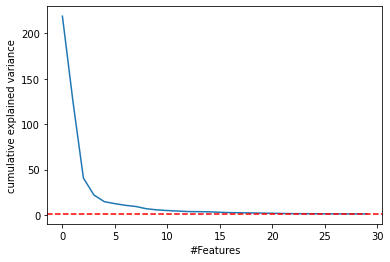

In [242]:
plt.plot(pca.explained_variance_[0:30])
plt.axhline(y=1, color='r', linestyle='--')
plt.xlabel('#Features')
plt.ylabel('cumulative explained variance');

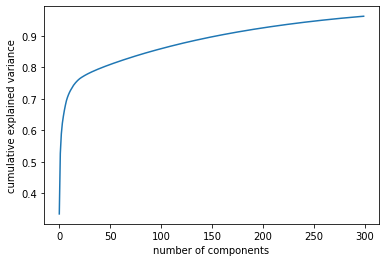

In [243]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

Agglomerating clustering

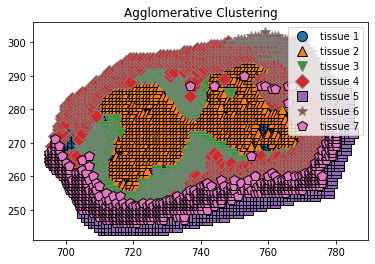

In [232]:
agg = AgglomerativeClustering(n_clusters=7)
assignment = agg.fit_predict(binMat) # x_pca  #fit_predict(data)
mglearn.discrete_scatter(cList[:,0], cList[:,1], assignment, labels=np.unique(assignment))
plt.legend(["tissue 1", "tissue 2", "tissue 3", "tissue 4", "tissue 5", "tissue 6", "tissue 7"], loc='upper right')
plt.title("Agglomerative Clustering")
plt.show()

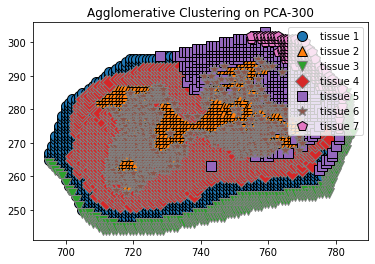

In [234]:
agg_pca = AgglomerativeClustering(n_clusters=7)
assignment_pca = agg.fit_predict(x_pca) # x_pca  #fit_predict(data)
mglearn.discrete_scatter(cList[:,0], cList[:,1], assignment_pca) #, labels=np.unique(assignment))
plt.legend(["tissue 1", "tissue 2", "tissue 3", "tissue 4", "tissue 5", "tissue 6", "tissue 7"], loc='upper right')
plt.title("Agglomerative Clustering on PCA-300")
plt.show()

In [231]:
segImg = np.zeros([84, 48])
for i, coord in enumerate(A[2]):
#     spectrum = self.imzObj.parser.getspectrum(self.imzObj.coord2index.get(coord)) #[0]
#     bSpec = self.onebinning(spectrum)
#     binned_mat[i] = bSpec
    xpos = coord[0]-xr[0]
    ypos = coord[1]-yr[0]
    segImg[xpos, ypos] = assignment[i]+10

NameError: name 'xr' is not defined

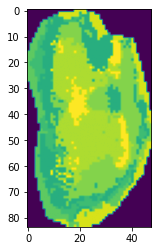

In [154]:
plt.imshow(segImg, cmap='viridis')

In [128]:
pca.components_.shape

(10, 1332)

In [235]:
from sklearn.decomposition import NMF
nmf = NMF(n_components=8, random_state=0)

In [236]:
binMat.shape

(3975, 1332)

In [237]:
from sklearn.manifold import TSNE
tsne = TSNE(random_state=42)

In [238]:
tsneData = tsne.fit_transform(binMat)

<module 'matplotlib.pyplot' from '/home/banikr2/.local/lib/python3.7/site-packages/matplotlib-3.5.0b1-py3.7-linux-x86_64.egg/matplotlib/pyplot.py'>

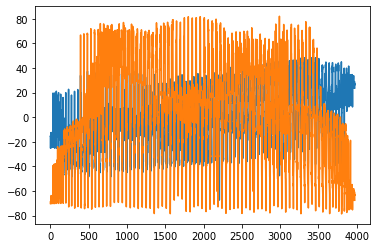

In [239]:
plt.plot(tsneData)
plt

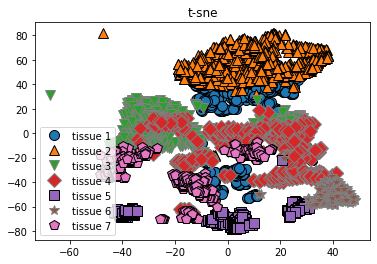

In [240]:
mglearn.discrete_scatter(tsneData[:,0], tsneData[:,1], assignment)
plt.legend(["tissue 1", "tissue 2", "tissue 3", "tissue 4", "tissue 5", "tissue 6", "tissue 7"], loc='lower left')
plt.title("t-sne")
plt.show()

In [44]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=7)

In [46]:
kmData = kmeans.fit(binMat)

In [50]:
# mglearn.discrete_scatter(kmData)
np.unique(kmData.labels_)

array([0, 1, 2, 3, 4, 5, 6], dtype=int32)

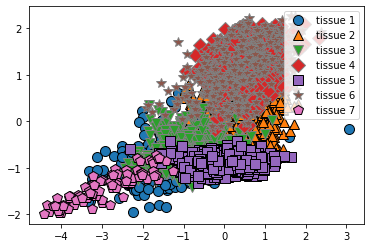

In [110]:
mglearn.discrete_scatter(binMat[:,0], binMat[:,91], kmData.labels_, labels=np.unique(kmData.labels_))
plt.legend(["tissue 1", "tissue 2", "tissue 3", "tissue 4", "tissue 5", "tissue 6", "tissue 7"], loc='upper right')
plt.show()

### DBSCAN
another clustering algorithm **Density Based Spatial Clustering of Applications with Noise**

In [134]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=15, min_samples=2)

In [135]:
clusters = dbscan.fit_predict(binMat)

In [136]:
clusters

array([-1, -1,  0, ...,  4,  4,  4])

In [137]:
np.unique(clusters)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32])

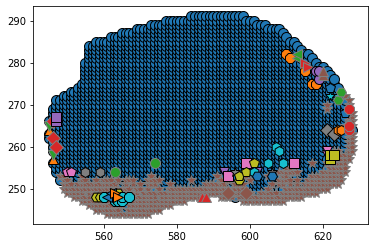

In [170]:
mglearn.discrete_scatter(cList[:,0], cList[:,1], clusters)
plt.show()

In [149]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators=5, random_state=2)
forest.fit(binMat, assignment)

RandomForestClassifier(n_estimators=5, random_state=2)

In [154]:
binMat.shape

(3142, 1332)

In [157]:
from sklearn.svm import SVC

In [158]:
svm = SVC()
svm.fit(binMat, assignment)

SVC()

In [159]:
svm.score(binMat, assignment)

0.9910884786760026

In [171]:
mglearn.discrete_scatter(svm.decision_function)

TypeError: discrete_scatter() missing 1 required positional argument: 'x2'

In [161]:
svm.classes_

array([0, 1, 2, 3, 4, 5, 6])

In [179]:
svm.decision_function(binMat)[0,:]

array([ 4.22527292,  5.213649  ,  0.72983293,  2.85486707,  1.79695193,
       -0.26773656,  6.29069931])

In [172]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

In [241]:
# plot_svc_decision_function(svm)

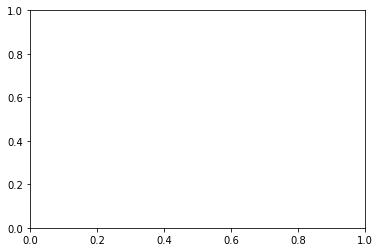

In [175]:
ax = plt.gca()

In [185]:
from mpl_toolkits import mplot3d
from ipywidgets import interact, fixed

def plot_3D(elev=30, azim=30, X=binMat, y=assignment):
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], X[:, 2], c=y, s=50, cmap='autumn')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('r')

interact(plot_3D, elev=[-90, 90], azip=(-180, 180),
         X=fixed(binMat), y=fixed(assignment))

interactive(children=(Dropdown(description='elev', options=(-90, 90), value=-90), IntSlider(value=30, descript…

<function __main__.plot_3D(elev=30, azim=30, X=array([[ 1.01559466,  3.80395421,  1.13466601, ...,  0.        ,
         0.        , -0.24686615],
       [ 0.93494047,  2.14853693,  1.49126515, ...,  0.        ,
         0.        , -0.24686615],
       [-0.36184674,  0.69533174,  0.65204344, ...,  0.        ,
         0.        , -0.24686615],
       ...,
       [ 0.45353247, -0.26126434, -0.4258016 , ...,  0.        ,
         0.        , -0.24686615],
       [ 0.14667414, -0.07467927, -0.73899743, ...,  0.        ,
         0.        , -0.24686615],
       [ 0.562437  , -0.04051135, -1.2191097 , ...,  0.        ,
         0.        , -0.24686615]]), y=array([6, 6, 6, ..., 1, 1, 1]))>

peak picked Chen rat

In [2]:
dataPath = r'/media/banikr2/DATA/MALDI/fromCardinal/ChenRat'
imzPath = glob(os.path.join(dataPath, '*.imzML'))
print(imzPath[0])

/media/banikr2/DATA/MALDI/fromCardinal/ChenRat/210622_TC380_Chen_Rat.imzML


/home/banikr2/.local/lib/python3.7/site-packages/pyimzML-1.5.1-py3.7.egg/pyimzml/ontology/ontology.py:94: UserWarning: Accession IMS:1000042 found with incorrect name "max count of pixel x". Updating name to "max count of pixels x".
  % (accession, raw_name, name)
/home/banikr2/.local/lib/python3.7/site-packages/pyimzML-1.5.1-py3.7.egg/pyimzml/ontology/ontology.py:94: UserWarning: Accession IMS:1000043 found with incorrect name "max count of pixel y". Updating name to "max count of pixels y".
  % (accession, raw_name, name)
/home/banikr2/.local/lib/python3.7/site-packages/pyimzML-1.5.1-py3.7.egg/pyimzml/ontology/ontology.py:94: UserWarning: Accession IMS:1000046 found with incorrect name "pixel size x". Updating name to "pixel size (x)".
  % (accession, raw_name, name)
Detecting Regions


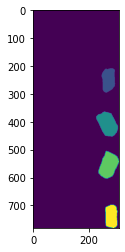

Detecting Regions Finished


In [3]:
imze = IMZMLExtract(imzPath[0])

In [4]:
imze.get_region_indices(1)

{(209, 275, 1): 6870,
 (209, 276, 1): 6949,
 (209, 277, 1): 7028,
 (209, 278, 1): 7106,
 (209, 279, 1): 7184,
 (209, 280, 1): 7261,
 (209, 281, 1): 7337,
 (209, 282, 1): 7413,
 (209, 283, 1): 7488,
 (209, 284, 1): 7562,
 (210, 260, 1): 5637,
 (210, 261, 1): 5723,
 (210, 270, 1): 6469,
 (210, 271, 1): 6550,
 (210, 272, 1): 6631,
 (210, 273, 1): 6711,
 (210, 274, 1): 6791,
 (210, 275, 1): 6871,
 (210, 276, 1): 6950,
 (210, 277, 1): 7029,
 (210, 278, 1): 7107,
 (210, 279, 1): 7185,
 (210, 280, 1): 7262,
 (210, 281, 1): 7338,
 (210, 282, 1): 7414,
 (210, 283, 1): 7489,
 (210, 284, 1): 7563,
 (210, 285, 1): 7635,
 (210, 286, 1): 7705,
 (211, 258, 1): 5469,
 (211, 259, 1): 5553,
 (211, 260, 1): 5638,
 (211, 261, 1): 5724,
 (211, 262, 1): 5809,
 (211, 263, 1): 5894,
 (211, 268, 1): 6306,
 (211, 269, 1): 6388,
 (211, 270, 1): 6470,
 (211, 271, 1): 6551,
 (211, 272, 1): 6632,
 (211, 273, 1): 6712,
 (211, 274, 1): 6792,
 (211, 275, 1): 6872,
 (211, 276, 1): 6951,
 (211, 277, 1): 7030,
 (211, 278

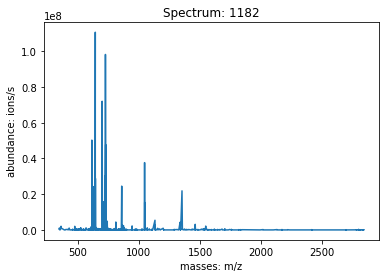

In [5]:
plt.plot(imze.parser.getspectrum(1182)[0], imze.parser.getspectrum(1182)[1])
plt.title("Spectrum: 1182")
plt.xlabel("masses: m/z")
plt.ylabel("abundance: ions/s")
plt.show()

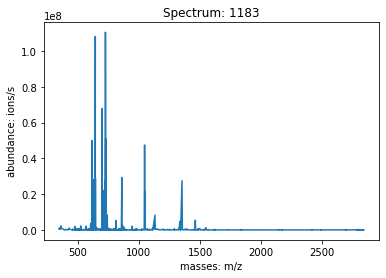

In [12]:
plt.plot(imze.parser.getspectrum(1183)[0], imze.parser.getspectrum(1183)[1])
plt.title("Spectrum: 1183")
plt.xlabel("masses: m/z")
plt.ylabel("abundance: ions/s")
plt.show()

In [11]:
np.shape(imze.parser.getspectrum(100)[0]), np.shape(imze.parser.getspectrum(1070)[0]), np.shape(imze.parser.getspectrum(140)[0])

((1255,), (1255,), (1255,))

all the mz lengths are same...

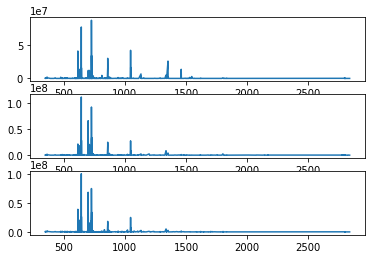

In [13]:
plt.subplot(311)
plt.plot(imze.parser.getspectrum(12)[0], imze.parser.getspectrum(12)[1])
plt.subplot(312)
plt.plot(imze.parser.getspectrum(600)[0], imze.parser.getspectrum(600)[1])
plt.subplot(313)
plt.plot(imze.parser.getspectrum(1331)[0], imze.parser.getspectrum(1331)[1])
plt.show()

In [ ]:
pca = PCA(n_components=300)
# pca.fit_transform(binMat)
pca.fit(binMat)
x_pca = pca.transform(binMat)
print(x_pca.shape)
plt.figure(figsize=(8, 8))
plt.subplot(211)
plt.scatter(x_pca[:, 0], x_pca[:, 1])
mglearn.discrete_scatter(x_pca[:, 0], x_pca[:, 1])
plt.subplot(212)
mglearn.discrete_scatter(x_pca[:, 0], x_pca[:, 1], assignment)
# plt.legend(assignment)
plt.xlabel("Feature-1")
plt.ylabel("Feature-2")
plt.legend(["tissue 1", "tissue 2", "tissue 3", "tissue 4", "tissue 5", "tissue 6", "tissue 7"], loc='upper right')
plt.show()

In [15]:
len(imze.mzValues)

1255

In [25]:
BinMat = Binning2(imzObj=imze, regionID=1)

In [26]:
A = BinMat.getBinMat()

In [27]:
np.shape(A[1])

(3343, 1255)

In [28]:
binMat = StandardScaler().fit_transform(A[1])

In [30]:
A[1].max(), A[1].min()

(172572768.0, 0.0)

In [31]:
binMat.shape

(3343, 1255)

In [33]:
binMat.max(), binMat.min()

(38.109059803226295, -5.773064020204717)

(3343, 300)


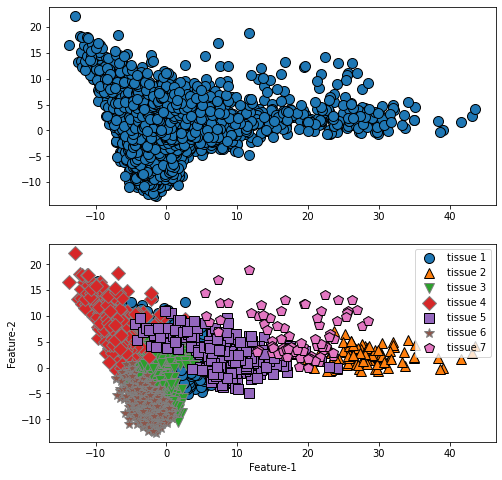

In [38]:
pca = PCA(n_components=300)
# pca.fit_transform(binMat)
pca.fit(binMat)
x_pca = pca.transform(binMat)
print(x_pca.shape)
plt.figure(figsize=(8, 8))
plt.subplot(211)
plt.scatter(x_pca[:, 0], x_pca[:, 1])
mglearn.discrete_scatter(x_pca[:, 0], x_pca[:, 1])
plt.subplot(212)
mglearn.discrete_scatter(x_pca[:, 0], x_pca[:, 1], assignment)
# plt.legend(assignment)
plt.xlabel("Feature-1")
plt.ylabel("Feature-2")
plt.legend(["tissue 1", "tissue 2", "tissue 3", "tissue 4", "tissue 5", "tissue 6", "tissue 7"], loc='upper right')
plt.show()

In [36]:
cList = np.array(A[2])
cList.shape

(3343, 3)

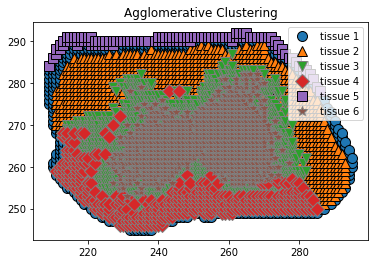

In [39]:
agg = AgglomerativeClustering(n_clusters=6)
assignment = agg.fit_predict(binMat) # x_pca  #fit_predict(data)
mglearn.discrete_scatter(cList[:,0], cList[:,1], assignment, labels=np.unique(assignment))
plt.legend(["tissue 1", "tissue 2", "tissue 3", "tissue 4", "tissue 5", "tissue 6", "tissue 7"], loc='upper right')
plt.title("Agglomerative Clustering")
plt.show()

## <span style="color:Purple">What about the MR data?  <span> 
using HeadSeg36 environment

In [28]:
import nibabel as nib
from glob import glob
import os
import matplotlib.pylab as plt
import numpy as np

In [9]:
week1Path = r'/media/banikr2/DATA/MALDI/from_Chase/MaldiRatNii/MaldiRat/Week 1/epip1_rgpulse_ratsc_1uT_19.img'

In [10]:
files = glob(os.path.join(week1Path, '*.nii'))

In [11]:
files

['/media/banikr2/DATA/MALDI/from_Chase/MaldiRatNii/MaldiRat/Week 1/epip1_rgpulse_ratsc_1uT_19.img/slice001image015echo001.nii',
 '/media/banikr2/DATA/MALDI/from_Chase/MaldiRatNii/MaldiRat/Week 1/epip1_rgpulse_ratsc_1uT_19.img/slice001image016echo001.nii',
 '/media/banikr2/DATA/MALDI/from_Chase/MaldiRatNii/MaldiRat/Week 1/epip1_rgpulse_ratsc_1uT_19.img/slice001image017echo001.nii',
 '/media/banikr2/DATA/MALDI/from_Chase/MaldiRatNii/MaldiRat/Week 1/epip1_rgpulse_ratsc_1uT_19.img/slice001image018echo001.nii',
 '/media/banikr2/DATA/MALDI/from_Chase/MaldiRatNii/MaldiRat/Week 1/epip1_rgpulse_ratsc_1uT_19.img/slice001image019echo001.nii',
 '/media/banikr2/DATA/MALDI/from_Chase/MaldiRatNii/MaldiRat/Week 1/epip1_rgpulse_ratsc_1uT_19.img/slice001image020echo001.nii',
 '/media/banikr2/DATA/MALDI/from_Chase/MaldiRatNii/MaldiRat/Week 1/epip1_rgpulse_ratsc_1uT_19.img/slice001image022echo001.nii',
 '/media/banikr2/DATA/MALDI/from_Chase/MaldiRatNii/MaldiRat/Week 1/epip1_rgpulse_ratsc_1uT_19.img/slice0

In [17]:
img = nib.load(files[0]).get_fdata()

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [18]:
img.shape

(96, 96)

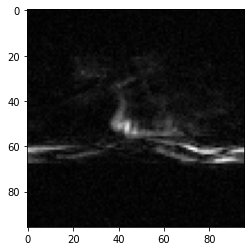

In [23]:
plt.imshow(img, cmap='gray')
plt.show()

In [25]:
img = nib.load(files[1]).get_fdata()
img.shape

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


(96, 96)

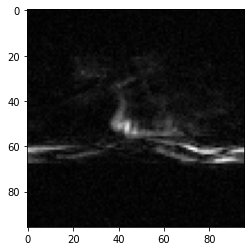

In [27]:
plt.imshow(img, cmap='gray')
plt.show()

In [34]:
img.shape[0]

96

In [38]:
img3D = np.zeros([img.shape[0], img.shape[1], len(files)])
np.shape(img3D)

(96, 96, 34)

In [65]:
def createNii3D(folder, saveimg=False):
    """
    Take folder/path of slices and 
    returns stacked 3D image. Also saves the 3D image if True. 
    """
    files = glob(os.path.join(folder, '*.nii'))
    img = nib.load(files[0]).get_fdata()
    img3D = np.zeros([img.shape[0], img.shape[1], len(files)])
    for i, file in enumerate(files):
        img = nib.load(file).get_fdata()
        img3D[...,i] = img
    if saveimg:
        img = nib.load(file)
        img3D = nib.Nifti1Image(img3D, img.affine, img.header)
        nib.save(img3D, os.path.join(folder, 'axial_anatomical_0_3mm_5_qMT2.nii'))
    return img3D

In [66]:
img3 = createNii3D(r'/media/banikr2/DATA/MALDI/from_Chase/MaldiRatNii/MaldiRat/Week 1/gems_MT_anat_axial_13.img', True)

pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [45]:
img3.shape

(96, 96, 34)

In [ ]:
nib.save(nib.Nifti1Image(img3, np.eye(4)), os.path.join(week1Path, 'img3.nii'))

In [46]:
print(os.path.join(week1Path, 'img3.nii'))

/media/banikr2/DATA/MALDI/from_Chase/MaldiRatNii/MaldiRat/Week 1/epip1_rgpulse_ratsc_1uT_19.img/img3.nii


In [73]:
for i, file in enumerate(files):
    imgN = nib.load(file)
    print(os.path.basename(files[0]))
    print(imgN.affine, imgN.header)
    print("\n")

pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


axial_anatomical_0_3mm_5_qMT2.nii
[[ -1.    0.    0.   63.5]
 [  0.    1.    0.  -63.5]
 [  0.    0.    1.   -0. ]
 [  0.    0.    0.    1. ]] <class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b'          '
db_name         : b'                  '
extents         : 16384
session_error   : 0
regular         : b'r'
dim_info        : 32
dim             : [  3 128 128   5   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float64
bitpix          : 64
slice_start     : 0
pixdim          : [-1.  1.  1.  1.  1.  1.  1.  1.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'                                                                              

In [67]:
qMTpath = r'/media/banikr2/DATA/MALDI/from_Chase/MaldiRatNii/MaldiRat/Week 1/gems_MT_anat_axial_13.img'
files = glob(os.path.join(qMTpath, '*.nii'))
print(files)

['/media/banikr2/DATA/MALDI/from_Chase/MaldiRatNii/MaldiRat/Week 1/gems_MT_anat_axial_13.img/axial_anatomical_0_3mm_5_qMT2.nii', '/media/banikr2/DATA/MALDI/from_Chase/MaldiRatNii/MaldiRat/Week 1/gems_MT_anat_axial_13.img/slice001image001echo001.nii', '/media/banikr2/DATA/MALDI/from_Chase/MaldiRatNii/MaldiRat/Week 1/gems_MT_anat_axial_13.img/slice002image001echo001.nii', '/media/banikr2/DATA/MALDI/from_Chase/MaldiRatNii/MaldiRat/Week 1/gems_MT_anat_axial_13.img/slice003image001echo001.nii', '/media/banikr2/DATA/MALDI/from_Chase/MaldiRatNii/MaldiRat/Week 1/gems_MT_anat_axial_13.img/slice004image001echo001.nii', '/media/banikr2/DATA/MALDI/from_Chase/MaldiRatNii/MaldiRat/Week 1/gems_MT_anat_axial_13.img/slice005image001echo001.nii']


In [70]:
os.path.basename(files[0])

'axial_anatomical_0_3mm_5_qMT2.nii'

<img src="../Images/maldi_loc.jpg" alt="Drawing" style="width:500px;"/>

## <span style="color:Purple">Comparison between different images <span> 
will compare positive lipid, protein and negative lipid mass spectrometry images. How they vary spatially and in terms of spectrometry. All of the data are preprocessed by Cardinal tool. 

### <span style="color:Purple">1. Chen positive lipid</span> 

In [3]:
poslipPath = r'/media/banikr2/DATA/MALDI/fromCardinal/PosLip'
plipImzFile = glob(os.path.join(poslipPath, '*.imzML'))
print(plipImzFile)

['/media/banikr2/DATA/MALDI/fromCardinal/PosLip/210427-Chen_poslip-peakpicked.imzML']


In [4]:
imze = IMZMLExtract(plipImzFile[0])

/home/banikr2/.local/lib/python3.7/site-packages/pyimzML-1.5.1-py3.7.egg/pyimzml/ontology/ontology.py:94: UserWarning: Accession IMS:1000042 found with incorrect name "max count of pixel x". Updating name to "max count of pixels x".
  % (accession, raw_name, name)
/home/banikr2/.local/lib/python3.7/site-packages/pyimzML-1.5.1-py3.7.egg/pyimzml/ontology/ontology.py:94: UserWarning: Accession IMS:1000043 found with incorrect name "max count of pixel y". Updating name to "max count of pixels y".
  % (accession, raw_name, name)
/home/banikr2/.local/lib/python3.7/site-packages/pyimzML-1.5.1-py3.7.egg/pyimzml/ontology/ontology.py:94: UserWarning: Accession IMS:1000046 found with incorrect name "pixel size x". Updating name to "pixel size (x)".
  % (accession, raw_name, name)


Opening regions file for /media/banikr2/DATA/MALDI/fromCardinal/PosLip/210427-Chen_poslip-peakpicked.imzML
1 545 628 244 291
2 695 785 244 303
3 704 798 146 212
4 848 940 201 265
5 988 1071 220 273


1 ((545, 628, 244, 291), 3142)
2 ((695, 785, 244, 303), 3975)
3 ((704, 798, 146, 212), 4587)
4 ((848, 940, 201, 265), 4680)
5 ((988, 1071, 220, 273), 3435)


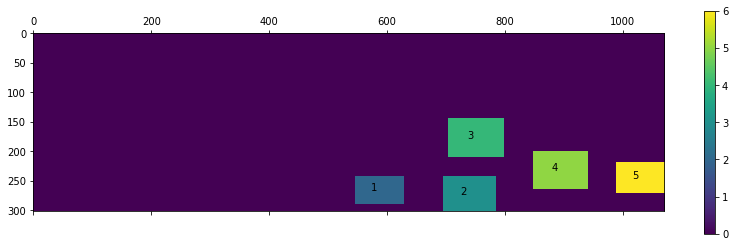

{1: ((545, 628, 244, 291), 3142),
 2: ((695, 785, 244, 303), 3975),
 3: ((704, 798, 146, 212), 4587),
 4: ((848, 940, 201, 265), 4680),
 5: ((988, 1071, 220, 273), 3435)}

In [5]:
imze.list_regions()

In [35]:
imze.parser.getspectrum(12)[0]


array([ 4961.034 ,  7061.2437,  7066.3013,  8565.909 , 14115.469 ,
       14195.128 , 14274.786 ], dtype=float32)

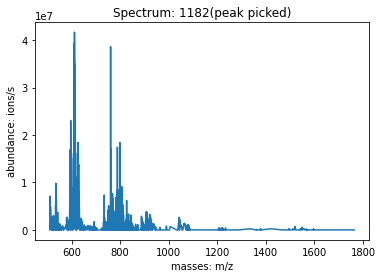

In [6]:
plt.plot(imze.parser.getspectrum(1182)[0], imze.parser.getspectrum(1182)[1])
plt.title("Spectrum: 1182(peak picked)")
plt.xlabel("masses: m/z")
plt.ylabel("abundance: ions/s")
plt.show()

In [7]:
spec_ = 2301
min(imze.parser.getspectrum(spec_)[0]), max(imze.parser.getspectrum(spec_)[0]), len(imze.parser.getspectrum(spec_)[0])

(510.18976, 1763.5247, 1332)

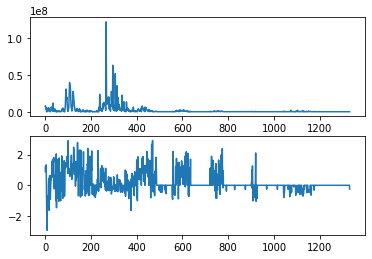

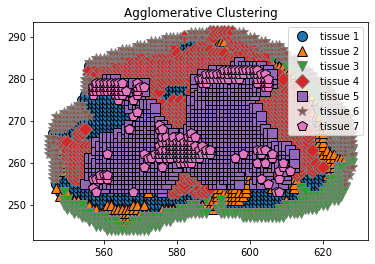

(3142, 300)


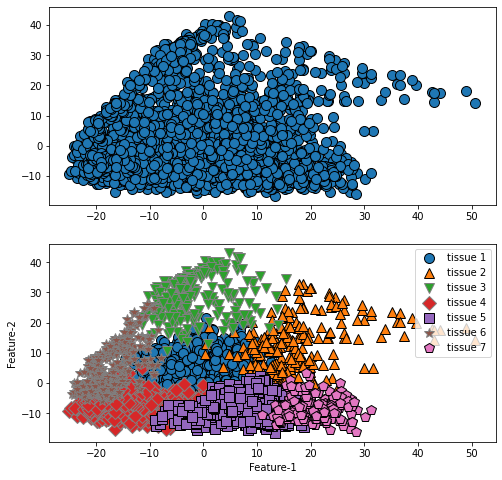

In [23]:
BinMat = Binning2(imzObj=imze, regionID=1)
regionBinned = BinMat.getBinMat()
np.shape(regionBinned[0]), np.shape(regionBinned[1])
np.max(regionBinned[1]), np.min(regionBinned[1]), np.mean(regionBinned[1]), np.std(regionBinned[1])
regSd = StandardScaler().fit_transform(regionBinned[1])
np.max(regSd[1]), np.min(regSd[1]), np.mean(regSd[1]), np.std(regSd[1])

plt.subplot(211)
plt.plot(regionBinned[1][301])
plt.subplot(212)
plt.plot(regSd[301])
plt.show()

cList = np.array(regionBinned[2])
agg = AgglomerativeClustering(n_clusters=7)
assignment = agg.fit_predict(regSd) # x_pca  #fit_predict(data)
mglearn.discrete_scatter(cList[:,0], cList[:,1], assignment, labels=np.unique(assignment))
plt.legend(["tissue 1", "tissue 2", "tissue 3", "tissue 4", "tissue 5", "tissue 6", "tissue 7"], loc='upper right')
plt.title("Agglomerative Clustering")
plt.show()

pca = PCA(n_components=300)
# pca.fit_transform(binMat)
pca.fit(regSd)
x_pca = pca.transform(regSd)
print(x_pca.shape)
plt.figure(figsize=(8, 8))
plt.subplot(211)
plt.scatter(x_pca[:, 0], x_pca[:, 1])
mglearn.discrete_scatter(x_pca[:, 0], x_pca[:, 1])
plt.subplot(212)
mglearn.discrete_scatter(x_pca[:, 0], x_pca[:, 1], assignment)
# plt.legend(assignment)
plt.xlabel("Feature-1")
plt.ylabel("Feature-2")
plt.legend(["tissue 1", "tissue 2", "tissue 3", "tissue 4", "tissue 5", "tissue 6", "tissue 7"], loc='upper right')
plt.show()

### <span style="color:Purple">2. Chen rat</span>

In [186]:
chenratPath = r'/media/banikr2/DATA/MALDI/fromCardinal/ChenRat'
cratImzFile = glob(os.path.join(chenratPath, '*.imzML'))
print(cratImzFile)

['/media/banikr2/DATA/MALDI/fromCardinal/ChenRat/210622_TC380_Chen_Rat.imzML']


/home/banikr2/.local/lib/python3.7/site-packages/pyimzML-1.5.1-py3.7.egg/pyimzml/ontology/ontology.py:94: UserWarning: Accession IMS:1000042 found with incorrect name "max count of pixel x". Updating name to "max count of pixels x".
  % (accession, raw_name, name)
/home/banikr2/.local/lib/python3.7/site-packages/pyimzML-1.5.1-py3.7.egg/pyimzml/ontology/ontology.py:94: UserWarning: Accession IMS:1000043 found with incorrect name "max count of pixel y". Updating name to "max count of pixels y".
  % (accession, raw_name, name)
/home/banikr2/.local/lib/python3.7/site-packages/pyimzML-1.5.1-py3.7.egg/pyimzml/ontology/ontology.py:94: UserWarning: Accession IMS:1000046 found with incorrect name "pixel size x". Updating name to "pixel size (x)".
  % (accession, raw_name, name)


Opening regions file for /media/banikr2/DATA/MALDI/fromCardinal/ChenRat/210622_TC380_Chen_Rat.imzML
1 209 295 245 292
2 364 452 226 302
3 505 603 233 306
4 698 780 258 301
1 ((209, 295, 245, 292), 3343)
2 ((364, 452, 226, 302), 4599)
3 ((505, 603, 233, 306), 4731)
4 ((698, 780, 258, 301), 3174)


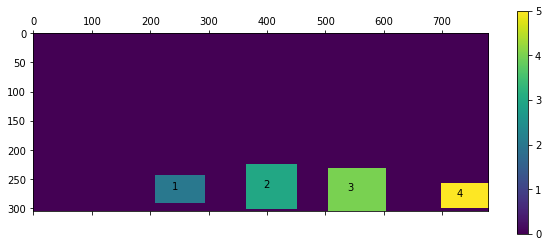

{1: ((209, 295, 245, 292), 3343),
 2: ((364, 452, 226, 302), 4599),
 3: ((505, 603, 233, 306), 4731),
 4: ((698, 780, 258, 301), 3174)}

In [187]:
imze = IMZMLExtract(cratImzFile[0])
imze.list_regions()

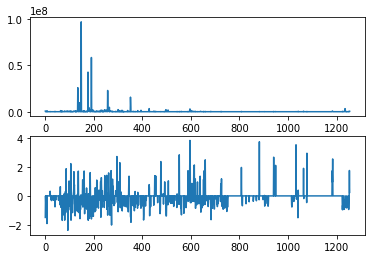

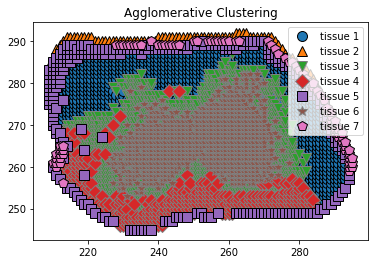

(3343, 300)


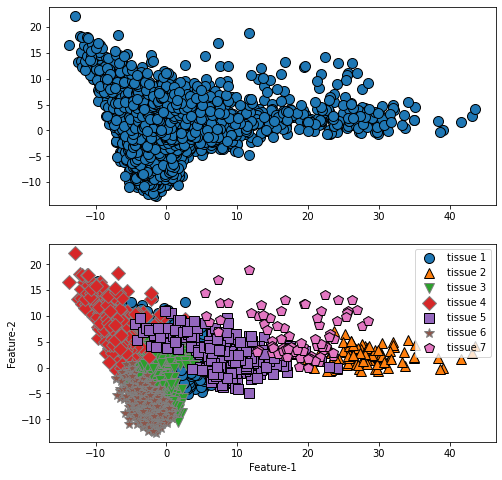

In [26]:
BinMat = Binning2(imzObj=imze, regionID=1)
regionBinned = BinMat.getBinMat()
np.shape(regionBinned[0]), np.shape(regionBinned[1])
np.max(regionBinned[1]), np.min(regionBinned[1]), np.mean(regionBinned[1]), np.std(regionBinned[1])
regSd = StandardScaler().fit_transform(regionBinned[1])
np.max(regSd[1]), np.min(regSd[1]), np.mean(regSd[1]), np.std(regSd[1])

plt.subplot(211)
plt.plot(regionBinned[1][301])
plt.subplot(212)
plt.plot(regSd[301])
plt.show()

cList = np.array(regionBinned[2])
agg = AgglomerativeClustering(n_clusters=7)
assignment = agg.fit_predict(regSd) # x_pca  #fit_predict(data)
mglearn.discrete_scatter(cList[:,0], cList[:,1], assignment, labels=np.unique(assignment))
plt.legend(["tissue 1", "tissue 2", "tissue 3", "tissue 4", "tissue 5", "tissue 6", "tissue 7"], loc='upper right')
plt.title("Agglomerative Clustering")
plt.show()

pca = PCA(n_components=300)
# pca.fit_transform(binMat)
pca.fit(regSd)
x_pca = pca.transform(regSd)
print(x_pca.shape)
plt.figure(figsize=(8, 8))
plt.subplot(211)
plt.scatter(x_pca[:, 0], x_pca[:, 1])
mglearn.discrete_scatter(x_pca[:, 0], x_pca[:, 1])
plt.subplot(212)
mglearn.discrete_scatter(x_pca[:, 0], x_pca[:, 1], assignment)
# plt.legend(assignment)
plt.xlabel("Feature-1")
plt.ylabel("Feature-2")
plt.legend(["tissue 1", "tissue 2", "tissue 3", "tissue 4", "tissue 5", "tissue 6", "tissue 7"], loc='upper right')
plt.show()

### <span style="color:Purple">3. Chen negative lipid</span>

In [27]:
neglipPath = r'/media/banikr2/DATA/MALDI/fromCardinal/NegLip'
nlipImzFile = glob(os.path.join(neglipPath, '*.imzML'))
print(nlipImzFile)

['/media/banikr2/DATA/MALDI/fromCardinal/NegLip/210505-Chen-plateB_neg_lipid.imzML']


/home/banikr2/.local/lib/python3.7/site-packages/pyimzML-1.5.1-py3.7.egg/pyimzml/ontology/ontology.py:94: UserWarning: Accession IMS:1000042 found with incorrect name "max count of pixel x". Updating name to "max count of pixels x".
  % (accession, raw_name, name)
/home/banikr2/.local/lib/python3.7/site-packages/pyimzML-1.5.1-py3.7.egg/pyimzml/ontology/ontology.py:94: UserWarning: Accession IMS:1000043 found with incorrect name "max count of pixel y". Updating name to "max count of pixels y".
  % (accession, raw_name, name)
/home/banikr2/.local/lib/python3.7/site-packages/pyimzML-1.5.1-py3.7.egg/pyimzml/ontology/ontology.py:94: UserWarning: Accession IMS:1000046 found with incorrect name "pixel size x". Updating name to "pixel size (x)".
  % (accession, raw_name, name)


Opening regions file for /media/banikr2/DATA/MALDI/fromCardinal/NegLip/210505-Chen-plateB_neg_lipid.imzML
1 522 609 234 280
2 667 755 208 285
3 833 925 132 195
4 971 1054 186 236
1 ((522, 609, 234, 280), 3399)
2 ((667, 755, 208, 285), 4711)
3 ((833, 925, 132, 195), 4819)
4 ((971, 1054, 186, 236), 3281)


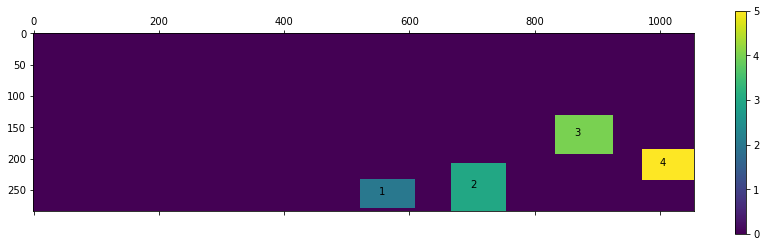

{1: ((522, 609, 234, 280), 3399),
 2: ((667, 755, 208, 285), 4711),
 3: ((833, 925, 132, 195), 4819),
 4: ((971, 1054, 186, 236), 3281)}

In [28]:
imze = IMZMLExtract(nlipImzFile[0])
imze.list_regions()

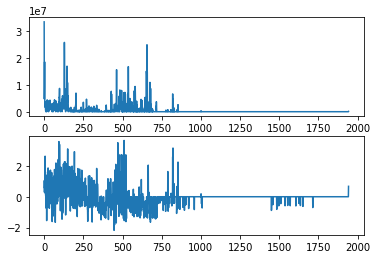

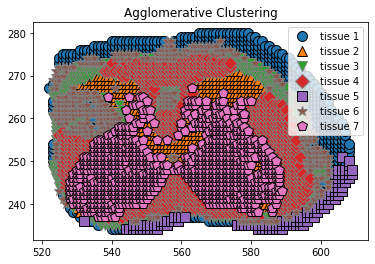

(3399, 300)


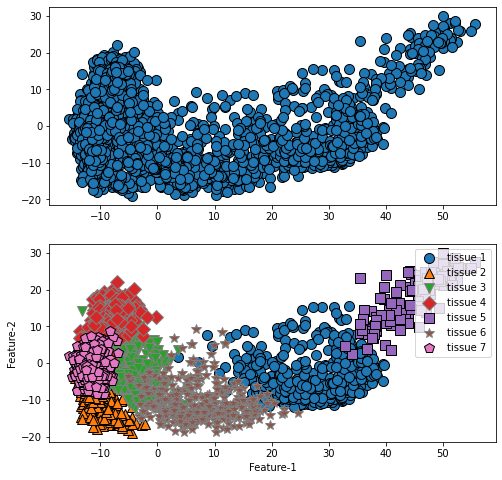

In [29]:
BinMat = Binning2(imzObj=imze, regionID=1)
regionBinned = BinMat.getBinMat()
np.shape(regionBinned[0]), np.shape(regionBinned[1])
np.max(regionBinned[1]), np.min(regionBinned[1]), np.mean(regionBinned[1]), np.std(regionBinned[1])
regSd = StandardScaler().fit_transform(regionBinned[1])
np.max(regSd[1]), np.min(regSd[1]), np.mean(regSd[1]), np.std(regSd[1])

plt.subplot(211)
plt.plot(regionBinned[1][301])
plt.subplot(212)
plt.plot(regSd[301])
plt.show()

cList = np.array(regionBinned[2])
agg = AgglomerativeClustering(n_clusters=7)
assignment = agg.fit_predict(regSd) # x_pca  #fit_predict(data)
mglearn.discrete_scatter(cList[:,0], cList[:,1], assignment, labels=np.unique(assignment))
plt.legend(["tissue 1", "tissue 2", "tissue 3", "tissue 4", "tissue 5", "tissue 6", "tissue 7"], loc='upper right')
plt.title("Agglomerative Clustering")
plt.show()

pca = PCA(n_components=300)
# pca.fit_transform(binMat)
pca.fit(regSd)
x_pca = pca.transform(regSd)
print(x_pca.shape)
plt.figure(figsize=(8, 8))
plt.subplot(211)
plt.scatter(x_pca[:, 0], x_pca[:, 1])
mglearn.discrete_scatter(x_pca[:, 0], x_pca[:, 1])
plt.subplot(212)
mglearn.discrete_scatter(x_pca[:, 0], x_pca[:, 1], assignment)
# plt.legend(assignment)
plt.xlabel("Feature-1")
plt.ylabel("Feature-2")
plt.legend(["tissue 1", "tissue 2", "tissue 3", "tissue 4", "tissue 5", "tissue 6", "tissue 7"], loc='upper right')
plt.show()

In [12]:
imze.mzValues

array([ 345.57327271,  346.00784302,  346.00817871, ..., 1997.80944824,
       1999.95959473, 1999.97058105])

In [15]:
spec_ = 23
min(imze.parser.getspectrum(spec_)[0]), max(imze.parser.getspectrum(spec_)[0]), len(imze.parser.getspectrum(spec_)[0])

(345.5732727050781, 1999.9705810546875, 34160)

In [16]:
spec_ = 230
min(imze.parser.getspectrum(spec_)[0]), max(imze.parser.getspectrum(spec_)[0]), len(imze.parser.getspectrum(spec_)[0])

(345.5732727050781, 1999.9705810546875, 34906)

### <span style="color:Purple">4. Chen protein</span>

In [189]:
proPath = r'/media/banikr2/DATA/MALDI/fromPrimatefmri/210603-Chen_protein_slide_F'
# proPath = r'/media/banikr2/DATA/MALDI/fromCardinal/Protein'
proImzFile = glob(os.path.join(proPath, '*.imzML'))
print(proImzFile)

['/media/banikr2/DATA/MALDI/fromPrimatefmri/210603-Chen_protein_slide_F/210603-Chen_protein_slide_F.imzML']


/home/banikr2/.local/lib/python3.7/site-packages/pyimzML-1.5.1-py3.7.egg/pyimzml/ontology/ontology.py:94: UserWarning: Accession IMS:1000046 found with incorrect name "pixel size". Updating name to "pixel size (x)".
  % (accession, raw_name, name)


Opening regions file for /media/banikr2/DATA/MALDI/fromPrimatefmri/210603-Chen_protein_slide_F/210603-Chen_protein_slide_F.imzML
1 530 620 224 280
2 675 771 202 275
3 823 920 194 253
4 952 1038 296 353
1 ((530, 620, 224, 280), 3527)
2 ((675, 771, 202, 275), 4902)
3 ((823, 920, 194, 253), 4593)
4 ((952, 1038, 296, 353), 3779)


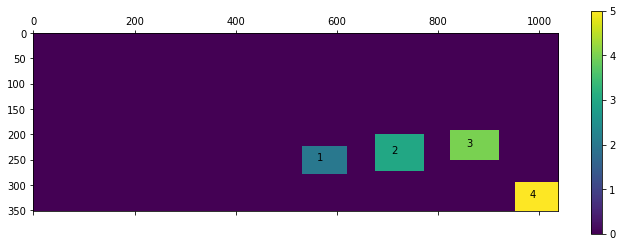

{1: ((530, 620, 224, 280), 3527),
 2: ((675, 771, 202, 275), 4902),
 3: ((823, 920, 194, 253), 4593),
 4: ((952, 1038, 296, 353), 3779)}

In [190]:
imze = IMZMLExtract(proImzFile[0])
imze.list_regions()

In [74]:
spec_ = 16800
min(imze.parser.getspectrum(spec_)[0]), max(imze.parser.getspectrum(spec_)[0]), len(imze.parser.getspectrum(spec_)[1])

(1593.8713350673997, 23214.268851716733, 17100)

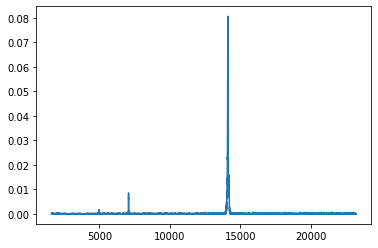

In [64]:
# plt.subplot(311)
# plt.plot(imze.parser.getspectrum(601)[0], imze.parser.getspectrum(12)[1])
# plt.subplot(312)
plt.plot(imze.parser.getspectrum(300)[0], imze.parser.getspectrum(300)[1])
# plt.subplot(313)
# plt.plot(imze.parser.getspectrum(13301)[0], imze.parser.getspectrum(1331)[1])
plt.show()

In [40]:
imze.parser.getspectrum(spec_)[0]

array([ 4961.034 ,  7061.2437,  7066.3013,  8565.909 , 14115.469 ,
       14195.128 , 14274.786 ], dtype=float32)

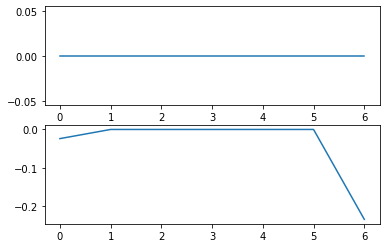

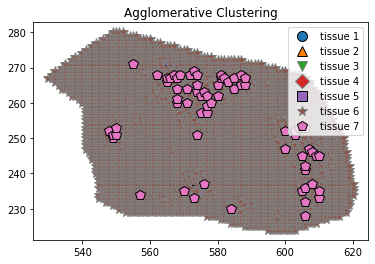

ValueError: n_components=300 must be between 0 and min(n_samples, n_features)=7 with svd_solver='full'

In [32]:
BinMat = Binning2(imzObj=imze, regionID=1)
regionBinned = BinMat.getBinMat()
np.shape(regionBinned[0]), np.shape(regionBinned[1])
np.max(regionBinned[1]), np.min(regionBinned[1]), np.mean(regionBinned[1]), np.std(regionBinned[1])
regSd = StandardScaler().fit_transform(regionBinned[1])
np.max(regSd[1]), np.min(regSd[1]), np.mean(regSd[1]), np.std(regSd[1])

plt.subplot(211)
plt.plot(regionBinned[1][301])
plt.subplot(212)
plt.plot(regSd[301])
plt.show()

cList = np.array(regionBinned[2])
agg = AgglomerativeClustering(n_clusters=7)
assignment = agg.fit_predict(regSd) # x_pca  #fit_predict(data)
mglearn.discrete_scatter(cList[:,0], cList[:,1], assignment, labels=np.unique(assignment))
plt.legend(["tissue 1", "tissue 2", "tissue 3", "tissue 4", "tissue 5", "tissue 6", "tissue 7"], loc='upper right')
plt.title("Agglomerative Clustering")
plt.show()

pca = PCA(n_components=300)
# pca.fit_transform(binMat)
pca.fit(regSd)
x_pca = pca.transform(regSd)
print(x_pca.shape)
plt.figure(figsize=(8, 8))
plt.subplot(211)
plt.scatter(x_pca[:, 0], x_pca[:, 1])
mglearn.discrete_scatter(x_pca[:, 0], x_pca[:, 1])
plt.subplot(212)
mglearn.discrete_scatter(x_pca[:, 0], x_pca[:, 1], assignment)
# plt.legend(assignment)
plt.xlabel("Feature-1")
plt.ylabel("Feature-2")
plt.legend(["tissue 1", "tissue 2", "tissue 3", "tissue 4", "tissue 5", "tissue 6", "tissue 7"], loc='upper right')
plt.show()

In [21]:
spec_ = 23
min(imze.parser.getspectrum(spec_)[0]), max(imze.parser.getspectrum(spec_)[0]), len(imze.parser.getspectrum(spec_)[0])

(1593.8713350673997, 23214.268851716733, 17100)

In [22]:
spec_ = 230
min(imze.parser.getspectrum(spec_)[0]), max(imze.parser.getspectrum(spec_)[0]), len(imze.parser.getspectrum(spec_)[0])

(1593.8713350673997, 23214.268851716733, 17100)

In [69]:
imze.parser.getspectrum(0)

(array([ 1593.87133507,  1595.13575974,  1596.40018442, ...,
        23211.74000237, 23213.00442704, 23214.26885172]),
 array([0.00205556, 0.00205556, 0.00205556, ..., 0.        , 0.        ,
        0.        ]))

In [70]:
imze.get_region_range(1)

((530, 620), (224, 280), (1, 1), 17100)

In [72]:
len(imze.parser.mzLengths)

16801

In [86]:
maxabun = 0
mxmz = [0, 0]
for i in range(len(imze.parser.mzLengths)):
#     print(i)
    mxa = max(imze.parser.getspectrum(i)[1])
    mxm = np.where(max(imze.parser.getspectrum(i)[1])==mxa)
    if mxa > maxabun:
        maxabun = mxa
        mxmz = [i, mxm]

In [79]:
maxabun

0.9054999947547913

In [145]:
maxabun = 0.9054999947547913
mxm = np.where(max(imze.parser.getspectrum(i)[1])==maxabun)
print(mxm)

(array([], dtype=int64),)


what is at ~14000?  

In [85]:
(imze.parser.getspectrum(110)[0] == imze.parser.getspectrum(100)[0]).all()

True

In [87]:
mxmz

[14203, (array([0]),)]

In [142]:
imze.parser.getspectrum(10)[0][14203]

19552.49499311585

In [89]:
imze.dregions

defaultdict(list,
            {1: [(530, 267, 1),
              (531, 267, 1),
              (531, 268, 1),
              (532, 266, 1),
              (532, 267, 1),
              (532, 268, 1),
              (532, 269, 1),
              (533, 265, 1),
              (533, 266, 1),
              (533, 267, 1),
              (533, 268, 1),
              (533, 269, 1),
              (534, 264, 1),
              (534, 265, 1),
              (534, 266, 1),
              (534, 267, 1),
              (534, 268, 1),
              (534, 269, 1),
              (534, 270, 1),
              (535, 264, 1),
              (535, 265, 1),
              (535, 266, 1),
              (535, 267, 1),
              (535, 268, 1),
              (535, 269, 1),
              (535, 270, 1),
              (535, 271, 1),
              (536, 263, 1),
              (536, 264, 1),
              (536, 265, 1),
              (536, 266, 1),
              (536, 267, 1),
              (536, 268, 1),
              (536, 26

In [90]:
len(imze.dregions)

4

In [109]:
imze.get_region_spectra(1)

|##############################################################################################################################################################################################| 100% Time: 0:00:00


KeyError: 0

Found region 1 with shape (91, 57, 17100)
Found region 1 with shape (91, 57, 17100)
Found region 1 with shape (91, 57, 17100)
Found region 1 with shape (91, 57, 17100)
Found region 1 with shape (91, 57, 17100)
Found region 1 with shape (91, 57, 17100)
Found region 1 with shape (91, 57, 17100)
Found region 1 with shape (91, 57, 17100)
Found region 1 with shape (91, 57, 17100)
Found region 1 with shape (91, 57, 17100)


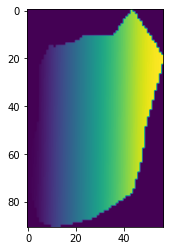

In [113]:
plt.imshow(imze.get_region_index_array(1))

In [95]:
allMaxX = 0
allMaxY = 0
for regionid in imze.dregions:
    allpixels = imze.dregions[regionid]
    minx = min([x[0] for x in allpixels])
    maxx = max([x[0] for x in allpixels])
    miny = min([x[1] for x in allpixels])
    maxy = max([x[1] for x in allpixels])
    allMaxX = max(maxx, allMaxX)
    allMaxY = max(maxy, allMaxY)

In [96]:
allMaxX, allMaxY

(1038, 353)

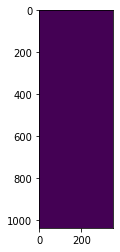

In [103]:
outimg = np.zeros([allMaxX, allMaxY])
plt.imshow(outimg)

In [100]:
outimg.shape

(1038, 353)

In [104]:
len(imze.get_region_spectra(1))

|##############################################################################################################################################################################################| 100% Time: 0:00:00


3527

In [105]:
allpixels

[(952, 322, 1),
 (952, 323, 1),
 (952, 324, 1),
 (952, 325, 1),
 (952, 326, 1),
 (952, 327, 1),
 (952, 328, 1),
 (952, 329, 1),
 (953, 318, 1),
 (953, 319, 1),
 (953, 320, 1),
 (953, 321, 1),
 (953, 322, 1),
 (953, 323, 1),
 (953, 324, 1),
 (953, 325, 1),
 (953, 326, 1),
 (953, 327, 1),
 (953, 328, 1),
 (953, 329, 1),
 (953, 330, 1),
 (953, 331, 1),
 (954, 315, 1),
 (954, 316, 1),
 (954, 317, 1),
 (954, 318, 1),
 (954, 319, 1),
 (954, 320, 1),
 (954, 321, 1),
 (954, 322, 1),
 (954, 323, 1),
 (954, 324, 1),
 (954, 325, 1),
 (954, 326, 1),
 (954, 327, 1),
 (954, 328, 1),
 (954, 329, 1),
 (954, 330, 1),
 (954, 331, 1),
 (954, 332, 1),
 (954, 333, 1),
 (955, 313, 1),
 (955, 314, 1),
 (955, 315, 1),
 (955, 316, 1),
 (955, 317, 1),
 (955, 318, 1),
 (955, 319, 1),
 (955, 320, 1),
 (955, 321, 1),
 (955, 322, 1),
 (955, 323, 1),
 (955, 324, 1),
 (955, 325, 1),
 (955, 326, 1),
 (955, 327, 1),
 (955, 328, 1),
 (955, 329, 1),
 (955, 330, 1),
 (955, 331, 1),
 (955, 332, 1),
 (955, 333, 1),
 (955, 3

In [209]:
imze.parser.coordinates[13860][0:2]

(1038, 310)

In [116]:
len(imze.coord2index)

16801

In [129]:
imze.coord2index[imze.parser.coordinates[1000]]

1000

In [210]:
outimg = np.zeros([allMaxX, allMaxY])
outimg[imze.parser.coordinates[1000][0:2]]
outimg[1038,9]

IndexError: index 1038 is out of bounds for axis 0 with size 1038

In [235]:
outimg = np.zeros([allMaxX+1, allMaxY+1])
for i in range(len(imze.coord2index)):
#     specID = imze.coord2index[imze.parser.coordinates[i]]
#     print(i)
    outimg[imze.parser.coordinates[i][0:2]] = imze.parser.getspectrum(i)[1][9903]

In [204]:
imze.parser.coordinates[11][0:2]

(590, 225)

In [234]:
imze.parser.getspectrum(1100)[0][9903]

14115.468890911503

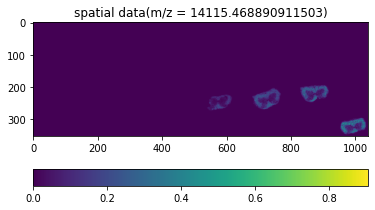

In [236]:
plt.imshow(outimg.T)
plt.title("spatial data(m/z = 14115.468890911503)")
plt.colorbar(orientation="horizontal")

In [200]:
outimg.shape

(1038, 353)

In [147]:
len(imze.parser.mzLengths), len(imze.coord2index)

(16801, 16801)

In [184]:
def plotmean(imze, pl=True):
    plotdata = np.zeros_like(imze.parser.getspectrum(0)[0])
    for i in range(len(imze.parser.mzLengths)):
        plotdata = plotdata + imze.parser.getspectrum(i)[1]
    pltd = plotdata/len(imze.parser.mzLengths)
    maxmzidx = np.where(pltd==max(pltd)) # index of m/z where max avg abundance found
    maxmzaAb = imze.parser.getspectrum(0)[0][maxmzidx] # m/z where max avg abundance is 
    if pl:
        plt.plot(imze.parser.getspectrum(0)[0], pltd)
        plt.xlabel("m/z")
        plt.ylabel("Mean intensity/abundance")
        plt.show()
    return pltd, maxmzidx, maxmzaAb

In [148]:
plotdata = np.zeros(len(imze.parser.getspectrum(0)[0]))

In [169]:
plotdata.shape, plotdata

((17100,), array([0., 0., 0., ..., 0., 0., 0.]))

In [167]:
plotdata = np.zeros_like(imze.parser.getspectrum(0)[0])

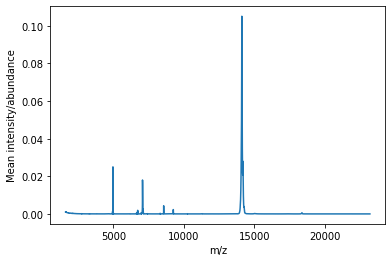

In [192]:
plotd = plotmean(imze)

In [193]:
plotd

(array([1.11339272e-03, 1.11339272e-03, 1.11339272e-03, ...,
        3.98785783e-05, 3.98785783e-05, 3.98785783e-05]),
 (array([9903]),),
 array([14115.46889091]))

In [173]:
print(plotd)

[1.11339272e-03 1.11339272e-03 1.11339272e-03 ... 3.98785783e-05
 3.98785783e-05 3.98785783e-05]


In [158]:
np.shape(imze.parser.getspectrum(i)[1])

(17100,)

In [163]:
[imze.parser.getspectrum(i)[1]]

[array([0.01144444, 0.01144444, 0.01144444, ..., 0.        , 0.        ,
        0.        ])]

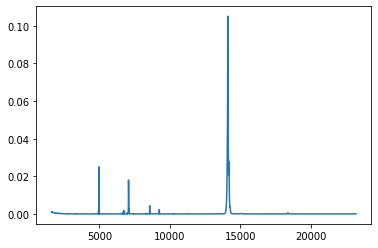

In [175]:
plt.plot(imze.parser.getspectrum(0)[0], plotd)

In [229]:
np.where(plotd==0.1047) #max(plotd))

(array([], dtype=int64),)

In [178]:
max(plotd)

0.10505990710171667

In [180]:
plotd[9903]

0.10505990710171667

In [181]:
imze.parser.getspectrum(0)[0][9903]

14115.468890911503

In [226]:
sortedplot = np.sort(plotd[0])
sortedplot[-2]

0.10470753723161373